In [1]:
import tensorflow as tf
import tensorflow_io as tfio

import os
from skimage.color import rgb2lab, lab2rgb
from matplotlib import pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split

In [2]:
# Hyper params
learning_rate = 1e-4
epochs = 500
batch_size = 64

# Prepare Data
- Lets load all images first 
- From there we're going to split our data with a 8:2 ratio for train and test
- Next step is to load our data into a dataset object
- Final step is to map our input into a readable format

In [3]:
def convert_image(image):
    byte_file = tf.io.read_file(image)
    img = tf.io.decode_jpeg(byte_file)
    img = tf.cast(img, tf.float32)
    img = img / 255.
    
    lab_img = tfio.experimental.color.rgb_to_lab(img) # Expects normalize img as input
    
    l_img = lab_img[:, :, 0] # Get only the L porition
    ab_img = lab_img[:, :, 1:] # Get the ab slice of the tensor
    
    return tf.expand_dims(l_img, axis=2) , ab_img / 128.

In [4]:
train_images = glob.glob('data/images/Train/*.jpg')
test_images = glob.glob('data/images/Test/*.jpg')

In [5]:
# When split we should set a state when we run again we can preserve the order
train_images, validation_images = train_test_split(train_images, test_size=0.2, random_state=2021) 

In [6]:
# Lets load our api into the tf dataset api
train_data = tf.data.Dataset.from_tensor_slices(train_images)
validation_data = tf.data.Dataset.from_tensor_slices(validation_images)

In [7]:
train_data = train_data.map(convert_image)
train_data = train_data.shuffle(len(train_images))
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

validation_data = validation_data.map(convert_image)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(tf.data.experimental.AUTOTUNE)

# Model Building
- For this example lets build an autoencoder 
- First examples are without transfer learning
- And lets use simple filters then go on to build complex layers

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 1)))

# The input layer
model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 1)))

# Encoder layer
# First stage
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2)))
model.add(tf.keras.layers.Activation('relu'))

# Second stage
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=(2, 2)))
model.add(tf.keras.layers.Activation('relu'))

# Third stage
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', strides=(2, 2)))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))

# Decoder Layer
model.add(tf.keras.layers.UpSampling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.UpSampling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(2, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.UpSampling2D((2, 2)))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 128)     0

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

In [11]:
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data
)

Epoch 1/500
105/105 [==============================] - 69s 653ms/step - loss: 0.0120 - val_loss: 0.0104
Epoch 2/500
105/105 [==============================] - 65s 623ms/step - loss: 0.0101 - val_loss: 0.0105
Epoch 3/500
105/105 [==============================] - 65s 623ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 4/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 5/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 6/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 7/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 8/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 9/500
105/105 [==============================] - 66s 629ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 10/500
105/105 [==============================] - 66s 629m

Epoch 77/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0041 - val_loss: 0.0113
Epoch 78/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0040 - val_loss: 0.0116
Epoch 79/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0039 - val_loss: 0.0114
Epoch 80/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0038 - val_loss: 0.0113
Epoch 81/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0037 - val_loss: 0.0112
Epoch 82/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0037 - val_loss: 0.0112
Epoch 83/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0036 - val_loss: 0.0112
Epoch 84/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0035 - val_loss: 0.0112
Epoch 85/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0036 - val_loss: 0.0112
Epoch 86/500
105/105 [==============================] -

105/105 [==============================] - 66s 628ms/step - loss: 0.0018 - val_loss: 0.0115
Epoch 155/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0018 - val_loss: 0.0116
Epoch 156/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0017 - val_loss: 0.0115
Epoch 157/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0018 - val_loss: 0.0116
Epoch 158/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0020 - val_loss: 0.0115
Epoch 159/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0017 - val_loss: 0.0115
Epoch 160/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0017 - val_loss: 0.0115
Epoch 161/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0017 - val_loss: 0.0116
Epoch 162/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0017 - val_loss: 0.0116
Epoch 163/500
105/105 [==============================] - 66s

105/105 [==============================] - 66s 626ms/step - loss: 0.0012 - val_loss: 0.0116
Epoch 232/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0012 - val_loss: 0.0116
Epoch 233/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 234/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0012 - val_loss: 0.0117
Epoch 235/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0012 - val_loss: 0.0118
Epoch 236/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0012 - val_loss: 0.0117
Epoch 237/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0012 - val_loss: 0.0116
Epoch 238/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0012 - val_loss: 0.0117
Epoch 239/500
105/105 [==============================] - 66s 626ms/step - loss: 0.0012 - val_loss: 0.0117
Epoch 240/500
105/105 [==============================] - 66s

105/105 [==============================] - 66s 627ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 309/500
105/105 [==============================] - 66s 625ms/step - loss: 0.0010 - val_loss: 0.0116
Epoch 310/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0010 - val_loss: 0.0118
Epoch 311/500
105/105 [==============================] - 66s 625ms/step - loss: 0.0010 - val_loss: 0.0117
Epoch 312/500
105/105 [==============================] - 66s 626ms/step - loss: 9.6154e-04 - val_loss: 0.0117
Epoch 313/500
105/105 [==============================] - 66s 626ms/step - loss: 9.8692e-04 - val_loss: 0.0117
Epoch 314/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0010 - val_loss: 0.0117
Epoch 315/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 316/500
105/105 [==============================] - 66s 627ms/step - loss: 0.0010 - val_loss: 0.0116
Epoch 317/500
105/105 [=============================

105/105 [==============================] - 66s 627ms/step - loss: 8.7854e-04 - val_loss: 0.0117
Epoch 384/500
105/105 [==============================] - 66s 628ms/step - loss: 8.8970e-04 - val_loss: 0.0118
Epoch 385/500
105/105 [==============================] - 66s 628ms/step - loss: 9.0320e-04 - val_loss: 0.0118
Epoch 386/500
105/105 [==============================] - 66s 627ms/step - loss: 9.0027e-04 - val_loss: 0.0118
Epoch 387/500
105/105 [==============================] - 66s 628ms/step - loss: 8.8631e-04 - val_loss: 0.0117
Epoch 388/500
105/105 [==============================] - 66s 629ms/step - loss: 8.7374e-04 - val_loss: 0.0117
Epoch 389/500
105/105 [==============================] - 66s 628ms/step - loss: 9.0098e-04 - val_loss: 0.0118
Epoch 390/500
105/105 [==============================] - 66s 629ms/step - loss: 9.3817e-04 - val_loss: 0.0117
Epoch 391/500
105/105 [==============================] - 66s 628ms/step - loss: 0.0010 - val_loss: 0.0117
Epoch 392/500
105/105 [=====

105/105 [==============================] - 66s 630ms/step - loss: 8.4624e-04 - val_loss: 0.0116
Epoch 458/500
105/105 [==============================] - 66s 630ms/step - loss: 8.0472e-04 - val_loss: 0.0118
Epoch 459/500
105/105 [==============================] - 66s 629ms/step - loss: 8.0855e-04 - val_loss: 0.0118
Epoch 460/500
105/105 [==============================] - 66s 629ms/step - loss: 8.2389e-04 - val_loss: 0.0118
Epoch 461/500
105/105 [==============================] - 66s 630ms/step - loss: 8.2101e-04 - val_loss: 0.0117
Epoch 462/500
105/105 [==============================] - 66s 630ms/step - loss: 8.7931e-04 - val_loss: 0.0118
Epoch 463/500
105/105 [==============================] - 66s 629ms/step - loss: 9.3050e-04 - val_loss: 0.0117
Epoch 464/500
105/105 [==============================] - 66s 627ms/step - loss: 9.3689e-04 - val_loss: 0.0116
Epoch 465/500
105/105 [==============================] - 66s 629ms/step - loss: 8.4124e-04 - val_loss: 0.0117
Epoch 466/500
105/105 [=

In [12]:
if not os.path.exists('model/'):
    os.makedirs('model')
    
model.save('model/color_autoencode.h5')

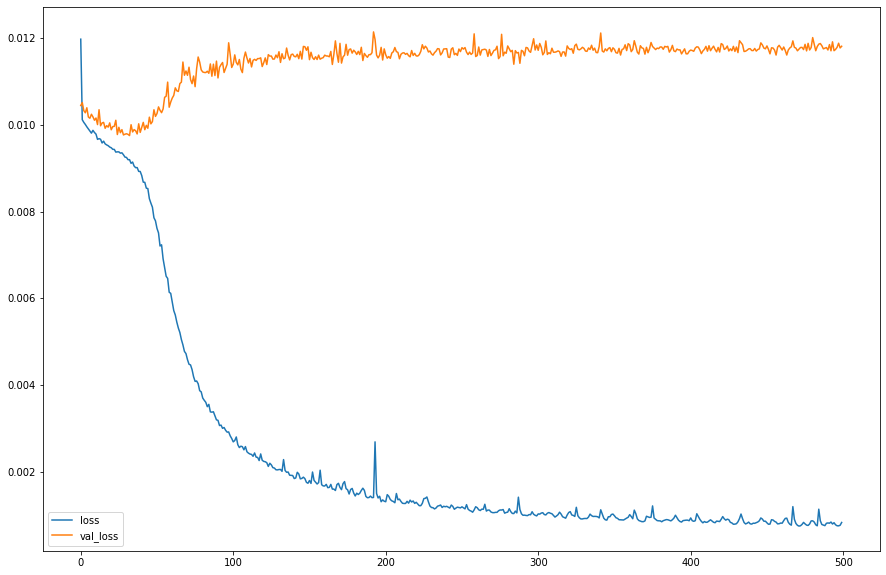

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()

# Evaluation

In [14]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if name == 'L':
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
    plt.show()

In [15]:
def read_image(image_path):
    return tf.io.decode_jpeg(tf.io.read_file(image_path))

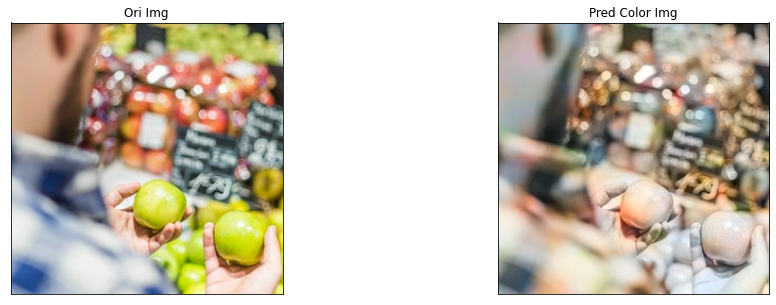

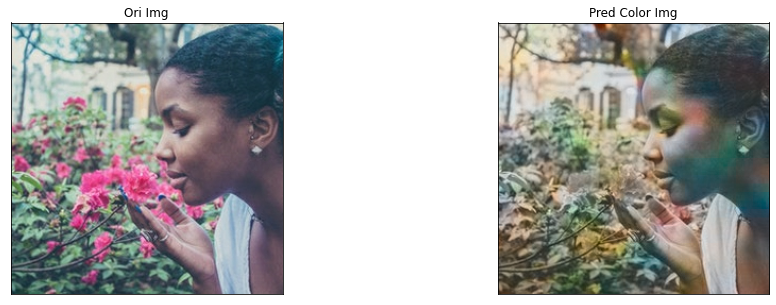

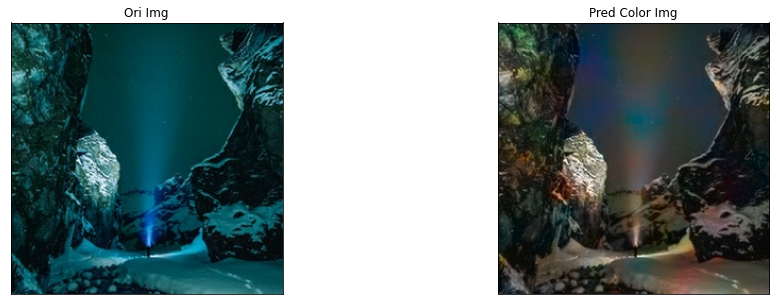

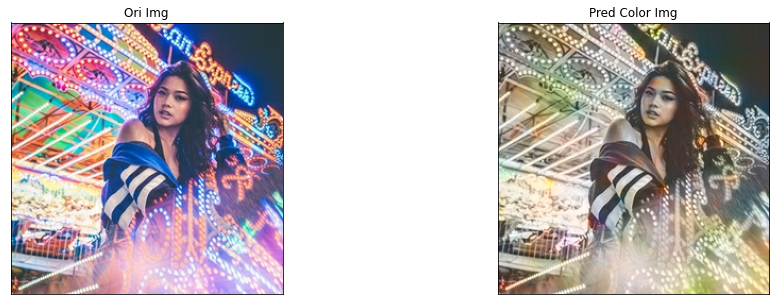

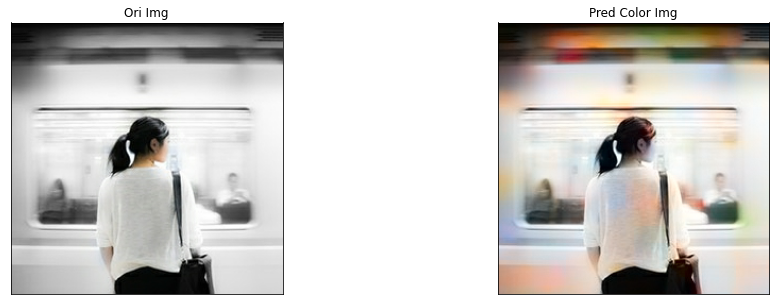

In [19]:
for test_image in np.random.choice(validation_images, size=5):
    l_tensor = convert_image(test_image)[0]

    pred_ab = model.predict(tf.expand_dims(l_tensor, axis=0))

    pred_ab = np.squeeze(pred_ab, axis=0)
    pred_ab = pred_ab * 128 # normalize ab 

    # Create an empty image and fill in with l, and ab
    lab_img = np.zeros((256, 256, 3))
    lab_img[:, :, 0] = np.squeeze(l_tensor.numpy(), axis=2)
    lab_img[:, :, 1:] = pred_ab

    visualize(
        ori_img=read_image(test_image),
        pred_color_img=tfio.experimental.color.lab_to_rgb(lab_img)
    )